# Popularity Model
The first model I want to try is a baseline model that recommends the most popular products to all users. There is no machine learning involved in this notebook, so all future models should outperform this (they will be more personalized). I expect this model to do poorly since people will buy what they need, not just the most popular items in a store. Since this model only finds the most popular products, there is no model training and thus no data preprocessing.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
import gzip
import json
import os
import gcsfs

from glob import glob
from matplotlib.ticker import FuncFormatter, MultipleLocator

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [8]:
train_df = pd.read_parquet("gs://amazon-reviews-project/filtered_train_df.parquet", engine="pyarrow")

In [9]:
train_df.head()

,user_id,parent_asin,rating,timestamp,history,category,title,average_rating,price,store,price_missing,datetime,year
0,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,B096WPNG8Q,5.00,1600542207688,None,Patio_Lawn_and_Garden,"Mosser Lee ML0560 Spanish Moss, 250 Cubic Inches",4.60,4.97,Mosser Lee,0,2020-09-19 19:03:27.688,2020
1,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,B000BQT5IG,3.00,1602272552200,B096WPNG8Q,Patio_Lawn_and_Garden,"Combat Indoor and Outdoor Ant Killing Gel, 27 ...",4.40,5.48,Combat,0,2020-10-09 19:42:32.200,2020
2,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,B002FGU2MI,4.00,1624053736863,B096WPNG8Q B000BQT5IG,Patio_Lawn_and_Garden,SWIMLINE HYDROTOOLS Mini Venturi Pool & Spa Va...,3.90,16.93,Swimline,0,2021-06-18 22:02:16.863,2021
3,AEFKF6R2GUSK2AWPSWRR4ZO36JVQ,B073V7N6RQ,5.00,1566941698710,None,Patio_Lawn_and_Garden,Raisman Rewind Recoil Starter Assembly Compati...,4.50,25.99,Raisman,0,2019-08-27 21:34:58.710,2019
4,AEFKF6R2GUSK2AWPSWRR4ZO36JVQ,B01J0RIRUS,4.00,1566941843328,B073V7N6RQ,Patio_Lawn_and_Garden,AUTOKAY Recoil Pull Start Compatible with Brig...,4.00,16.99,AUTOKAY,0,2019-08-27 21:37:23.328,2019


In [21]:
review_count = train_df.groupby("parent_asin").size().rename("review_count")
avg_rating = train_df.drop_duplicates(subset="parent_asin").set_index("parent_asin")[["average_rating"]]

In [28]:
review_count.head()

parent_asin
0000031895    14
000014357X     5
0005092663     5
000743619X     6
0008214255     4
Name: review_count, dtype: int64

In [23]:
avg_rating.head()

,average_rating
parent_asin,
B096WPNG8Q,4.60
B000BQT5IG,4.40
B002FGU2MI,3.90
B073V7N6RQ,4.50
B01J0RIRUS,4.00


We can calculate a popularity score for each product in each category and then recommend the most popular products to users for a specific category.

In [62]:
popularity_df = avg_rating.join(review_count)

# compute popularity score that balances review count with average ratings
popularity_df["popularity_score"] = popularity_df["average_rating"] * np.log1p(popularity_df["review_count"])

product_metadata = train_df.drop_duplicates("parent_asin")[["parent_asin", "category", "title"]].set_index("parent_asin")
popularity_df = popularity_df.join(product_metadata)

In [25]:
popularity_df.head()

,average_rating,review_count,popularity_score,category,title
parent_asin,,,,,
B096WPNG8Q,4.60,70,19.61,Patio_Lawn_and_Garden,"Mosser Lee ML0560 Spanish Moss, 250 Cubic Inches"
B000BQT5IG,4.40,322,25.42,Patio_Lawn_and_Garden,"Combat Indoor and Outdoor Ant Killing Gel, 27 ..."
B002FGU2MI,3.90,9,8.98,Patio_Lawn_and_Garden,SWIMLINE HYDROTOOLS Mini Venturi Pool & Spa Va...
B073V7N6RQ,4.50,10,10.79,Patio_Lawn_and_Garden,Raisman Rewind Recoil Starter Assembly Compati...
B01J0RIRUS,4.00,10,9.59,Patio_Lawn_and_Garden,AUTOKAY Recoil Pull Start Compatible with Brig...


In [63]:
popularity_df["popularity_score"].describe()

count   2870232.00
mean         11.07
std           4.71
min           0.69
25%           7.88
50%           9.89
75%          13.29
max          52.60
Name: popularity_score, dtype: float64

This offers a much more balanced way to evaluate popularity (isn't biased towards products with extremely high number of reviews)

In [64]:
popularity_df = popularity_df.reset_index()

# get top 10 products for each category
top_10_category = popularity_df.sort_values(["category", "popularity_score"], ascending=[True, False]).groupby("category").head(10)

top_10_dict = top_10_category.groupby("category")["parent_asin"].apply(list).to_dict()

In [42]:
top_10_dict

{'Arts_Crafts_and_Sewing': ['B001PNIWT2',
  'B07CSS3F58',
  'B003XWO1W0',
  'B01LY9ERQC',
  'B001R4T4VE',
  'B0C6HYJCV7',
  'B07H8KVNRP',
  'B09JHWHYYV',
  'B0C7CXW1JB',
  'B09583GNNB'],
 'Beauty_and_Personal_Care': ['B01LSUQSB0',
  'B07YT2VKTG',
  'B00HFG0FAM',
  'B0BVW6XYNZ',
  'B09KX5GC65',
  'B0C54M8QRC',
  'B0C2NNFV3Q',
  'B09GWLJPTH',
  'B0C5FCXJYP',
  'B0C4XSWGLH'],
 'Cell_Phones_and_Accessories': ['B01415QHYW',
  'B01LXZDPDR',
  'B01FKGEMIY',
  'B0BM9LK5TG',
  'B01KBQ6I3A',
  'B0BYS7ZYJ1',
  'B07H2V5YLH',
  'B01B14ANLY',
  'B06XQV5DDP',
  'B084TBCZ8Y'],
 'Clothing_Shoes_and_Jewelry': ['B07TVHSDMQ',
  'B08513YB2T',
  'B07QTVKNNQ',
  'B08DQ4CF7T',
  'B07BZGVBF7',
  'B00975EAJ6',
  'B0C5Y5NC8M',
  'B07T4WDPGJ',
  'B0BZDLXKTS',
  'B08P4SSFX4'],
 'Electronics': ['B07GZFM1ZM',
  'B075X8471B',
  'B01K8B8YA8',
  'B0791TX5P5',
  'B07H65KP63',
  'B07KTYJ769',
  'B011BRUOMO',
  'B0BGNG1294',
  'B083TH1B45',
  'B07HZLHPKP'],
 'Grocery_and_Gourmet_Food': ['B09PSVCKXS',
  'B0BTTNFBZD',
  'B0

Now, we want to load in the test dataset to evaluate the model. The data was split into training and testing segments based on a date threshold (every review after a specific date was put in the test data). This best models real world data science scenarios (where we only have access to past data).

In [35]:
# read test review data
fs = gcsfs.GCSFileSystem()

all_files = fs.glob("amazon-reviews-project/test_data/*.csv.gz")

test_dfs = []

for file in all_files:
    base = os.path.basename(file).replace(".csv.gz", "")
    category, _ = base.split('.', 1)

    with fs.open(file, 'rb') as f:
        df = pd.read_csv(f, compression='gzip')
        df['category'] = category

    test_dfs.append(df)

test_df = pd.concat(test_dfs, ignore_index=True)

In [65]:
# see if a user bought a popular product
test_df["correct_recommendation"] = test_df.apply(lambda row: int(row["parent_asin"] in top_10_dict.get(row["category"], [])), axis=1)

In [51]:
test_df.head()

,user_id,parent_asin,rating,timestamp,history,category,correct_recommendation
0,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B095RXT585,1.00,1661111719157,0913212148 B0BGXTQLL1 B0BV5ZGRRM B0BX9Y9RN8 B0...,Arts_Crafts_and_Sewing,0
1,AGPR2UDFIJJCBA3EKFEEAJBWKROQ,B075WTKK4T,5.00,1671550238314,B01JJ701C6 B0B2QG3S29 B01BO7VKJM B000YZ462E B0...,Arts_Crafts_and_Sewing,0
2,AFNT6ZJCYQN3WDIKUSWHJDXNND2Q,B0007XKHNA,4.00,1661229783567,B002YIP97K B09SRPZRN4 B002Y6CWCM B0042SYQTW,Arts_Crafts_and_Sewing,0
3,AFNT6ZJCYQN3WDIKUSWHJDXNND2Q,B07QQB9Y1C,4.00,1676007433140,B002YIP97K B09SRPZRN4 B002Y6CWCM B0042SYQTW B0...,Arts_Crafts_and_Sewing,0
4,AFNT6ZJCYQN3WDIKUSWHJDXNND2Q,B01EQHJH88,4.00,1676270899586,B002YIP97K B09SRPZRN4 B002Y6CWCM B0042SYQTW B0...,Arts_Crafts_and_Sewing,0


In [66]:
# calculating the hit rate (fraction of test data where bought product is in top 10)
hit_rate = test_df['correct_recommendation'].mean()
print(f"Hit Rate @10: {hit_rate:.2%}")

Hit Rate @10: 0.38%


This means 0.38% of the products that the model would suggest to users would be products they would actually buy. This is a very low percentage but serves as a good baseline.

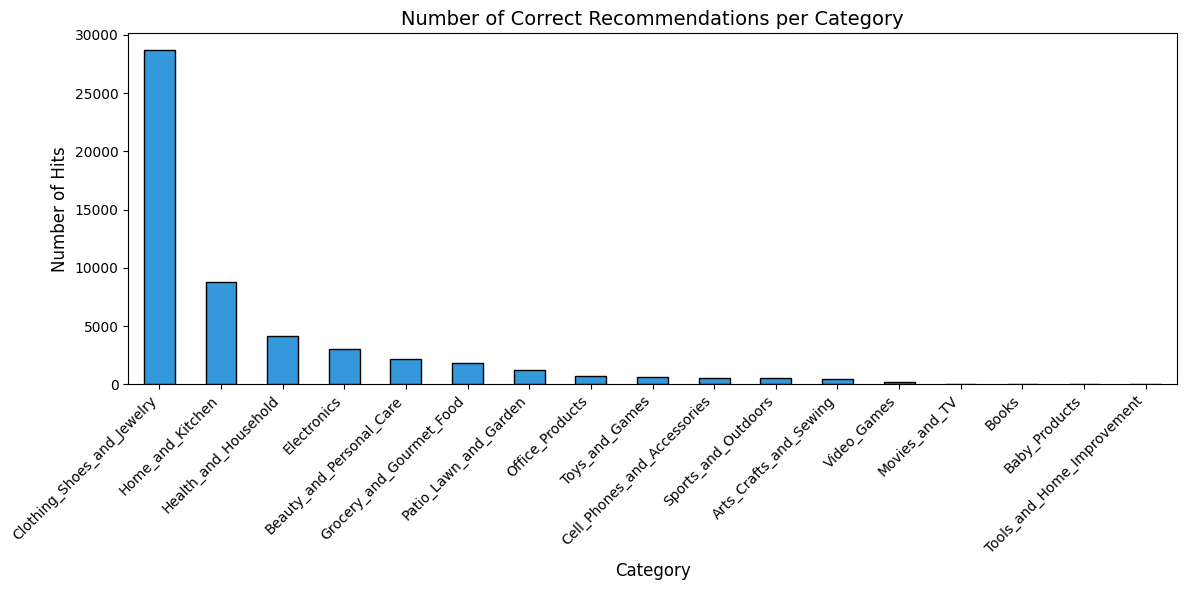

In [67]:
hits_per_category = test_df.groupby("category")["correct_recommendation"].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
hits_per_category.plot(kind="bar", color="#3498db", edgecolor="black")
plt.title("Number of Correct Recommendations per Category", fontsize=14)
plt.ylabel("Number of Hits", fontsize=12)
plt.xlabel("Category", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

We know clothing, shoes, and jewelry as well as home and kitchen are the categories with the most reviews, but we want to see if some customers buy popular products more in one category than another. Thus, I will plot the hit rate per category which will compare the hit rates between categories.

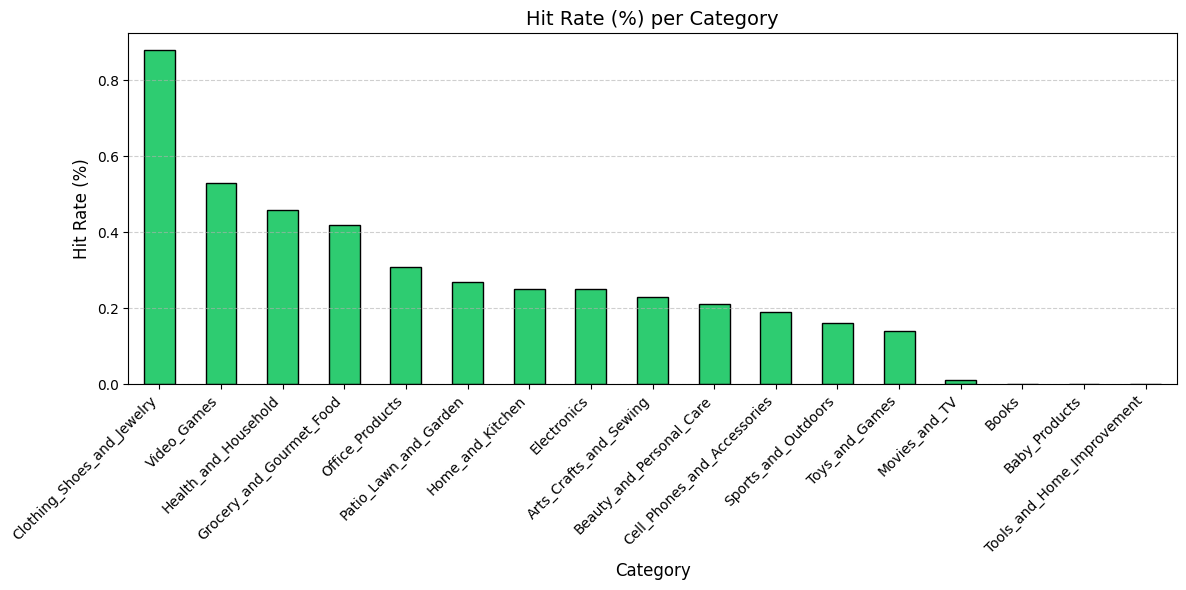

In [68]:
hit_rate_per_category = test_df.groupby("category")["correct_recommendation"].mean().mul(100).round(2).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
hit_rate_per_category.plot(kind="bar", color="#2ecc71", edgecolor="black")

plt.title("Hit Rate (%) per Category", fontsize=14)
plt.ylabel("Hit Rate (%)", fontsize=12)
plt.xlabel("Category", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

This shows that customers most prefer to buy popular products in the clothing, shoes, and jewelry category (0.8%). This makes sense as popular clothing or jewelry will often be part of trends or have status symbols associated with them.